In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency, pointbiserialr

In [5]:
train_data_path = "registros_entrenamiento-2.csv"
eval_data_path = "registros_evaluacion-2.csv"

**Paso 1: Análisis Exploratorio de Datos (EDA)**

In [6]:
train_df = pd.read_csv(train_data_path)

In [294]:
display(train_df.head())
display(train_df.info)
display(train_df.describe)

,IdPasajero,PlanetaOrigen,SuenoCriogenico,Cabina,Destino,Edad,ServicioVIP,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR,Transportado,Iniciales
0,004D8BSQ,NaN,False,C/268/S,TRAPPIST-1e,27.0,False,0.0,63.0,8.0,129.0,2960.0,False,YUW
1,009TL1XF,Europa,False,C/258/P,55 Cancri e,18.0,False,0.0,3492.0,0.0,506.0,8.0,True,SFW
2,00A9QC49,Europa,False,A/30/S,TRAPPIST-1e,44.0,True,1409.0,910.0,17.0,1452.0,3782.0,False,POY
3,00BJM5YI,Earth,False,E/24/P,TRAPPIST-1e,48.0,False,0.0,111.0,0.0,1508.0,0.0,False,ZIT
4,00DQRZAR,Mars,False,F/1550/P,TRAPPIST-1e,68.0,True,523.0,0.0,859.0,201.0,782.0,False,TJJ


<bound method DataFrame.info of      IdPasajero PlanetaOrigen SuenoCriogenico    Cabina        Destino  Edad  \
0      004D8BSQ           NaN           False   C/268/S    TRAPPIST-1e  27.0   
1      009TL1XF        Europa           False   C/258/P    55 Cancri e  18.0   
2      00A9QC49        Europa           False    A/30/S    TRAPPIST-1e  44.0   
3      00BJM5YI         Earth           False    E/24/P    TRAPPIST-1e  48.0   
4      00DQRZAR          Mars           False  F/1550/P    TRAPPIST-1e  68.0   
...         ...           ...             ...       ...            ...   ...   
7995   ZZCM7TR2          Mars           False   E/558/P    TRAPPIST-1e  36.0   
7996   ZZIMSTE2         Earth             NaN   F/946/S    TRAPPIST-1e  16.0   
7997   ZZKIIBBP         Earth            True    G/89/P  PSO J318.5-22  20.0   
7998   ZZLMOPKH        Europa           False    A/54/P    55 Cancri e  46.0   
7999   ZZLSM7SN         Earth            True   G/284/S    TRAPPIST-1e  24.0   

     Se

<bound method NDFrame.describe of      IdPasajero PlanetaOrigen SuenoCriogenico    Cabina        Destino  Edad  \
0      004D8BSQ           NaN           False   C/268/S    TRAPPIST-1e  27.0   
1      009TL1XF        Europa           False   C/258/P    55 Cancri e  18.0   
2      00A9QC49        Europa           False    A/30/S    TRAPPIST-1e  44.0   
3      00BJM5YI         Earth           False    E/24/P    TRAPPIST-1e  48.0   
4      00DQRZAR          Mars           False  F/1550/P    TRAPPIST-1e  68.0   
...         ...           ...             ...       ...            ...   ...   
7995   ZZCM7TR2          Mars           False   E/558/P    TRAPPIST-1e  36.0   
7996   ZZIMSTE2         Earth             NaN   F/946/S    TRAPPIST-1e  16.0   
7997   ZZKIIBBP         Earth            True    G/89/P  PSO J318.5-22  20.0   
7998   ZZLMOPKH        Europa           False    A/54/P    55 Cancri e  46.0   
7999   ZZLSM7SN         Earth            True   G/284/S    TRAPPIST-1e  24.0   

     

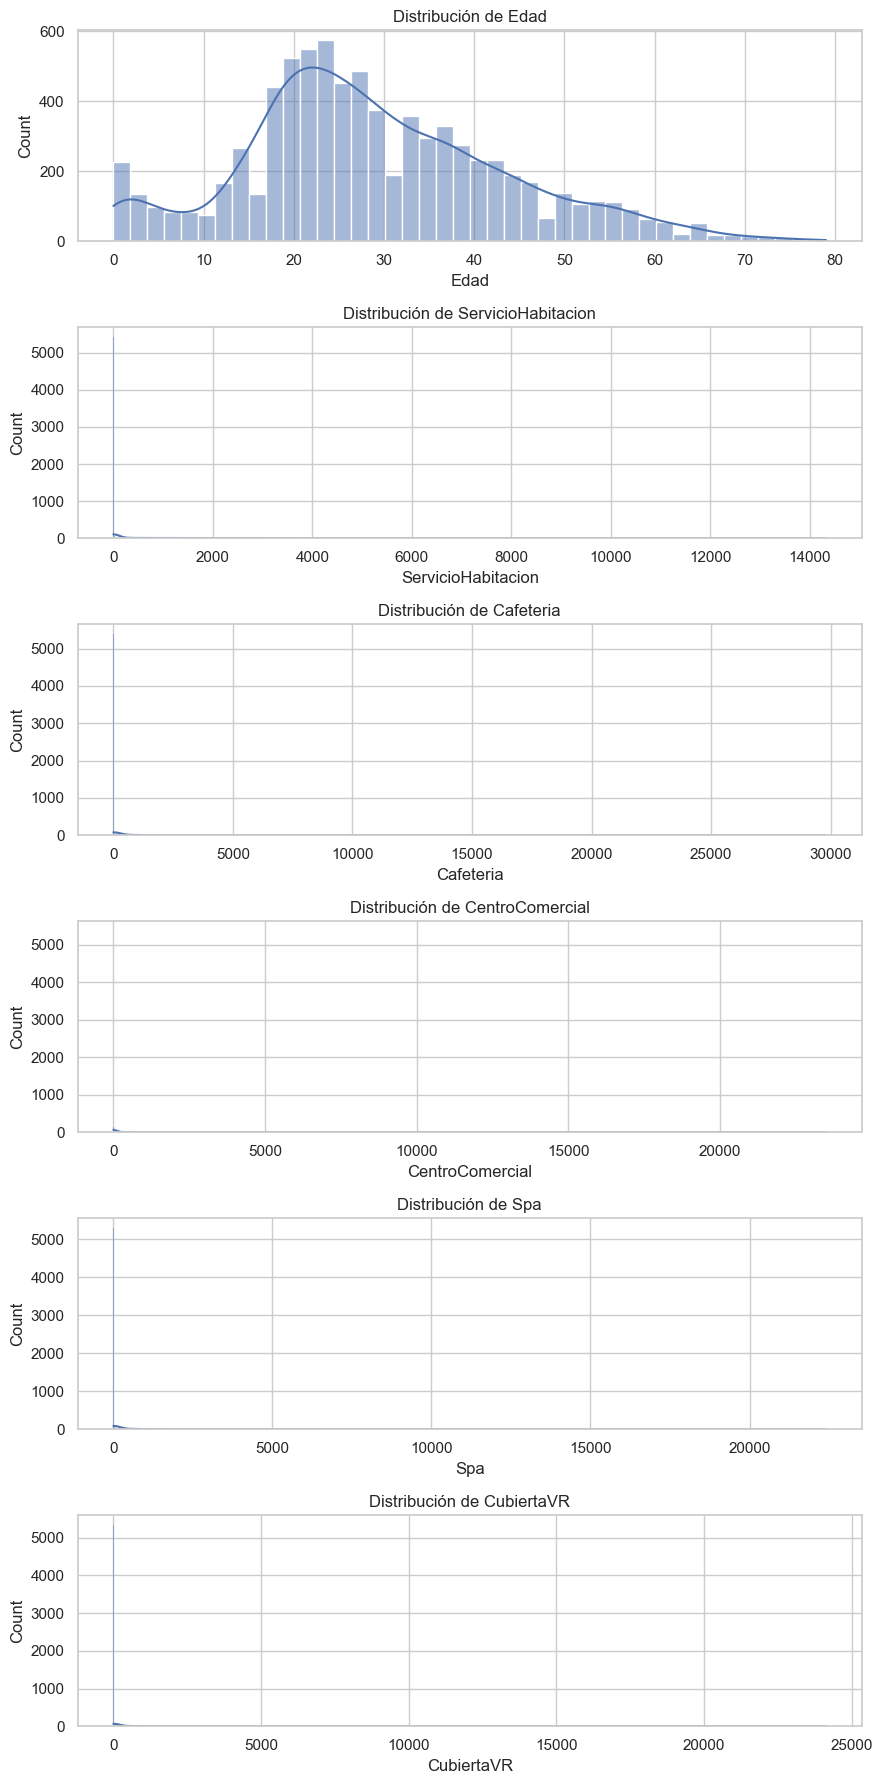

In [295]:
# Histogramas y KDE de variables numéricas clave
num_cols = train_df.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(9, len(num_cols)*3))
for ax, col in zip(axes, num_cols):
    sns.histplot(train_df[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

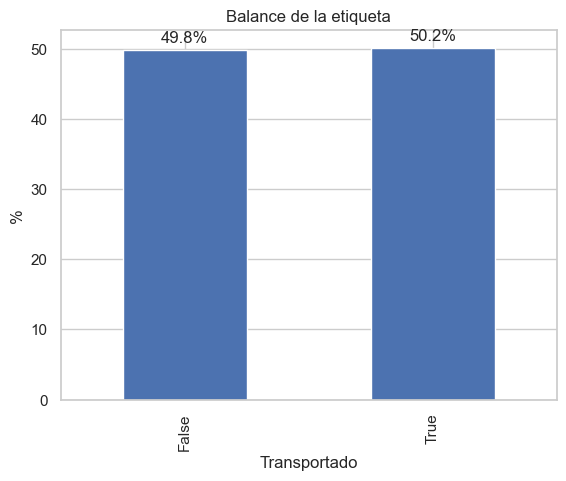

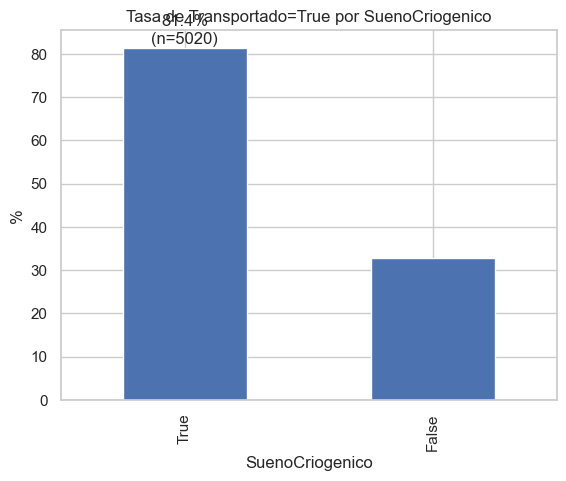

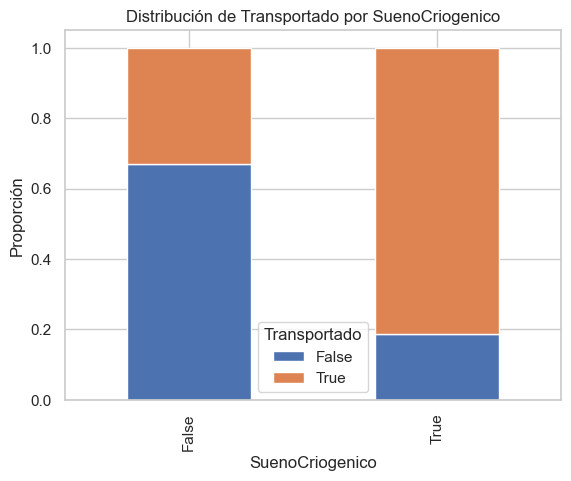

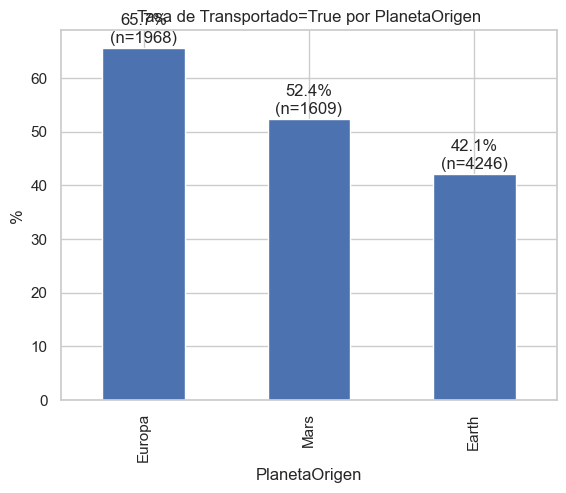

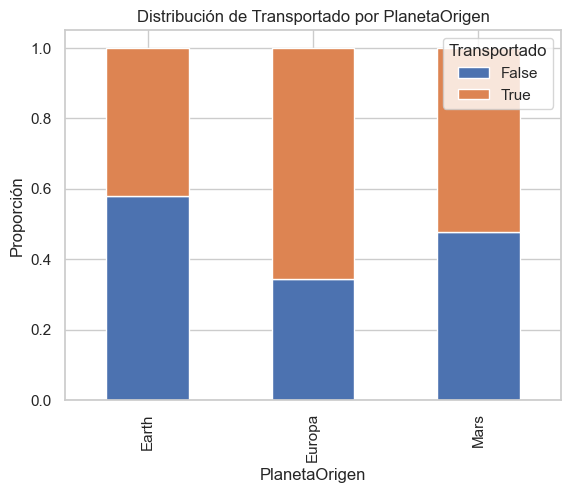

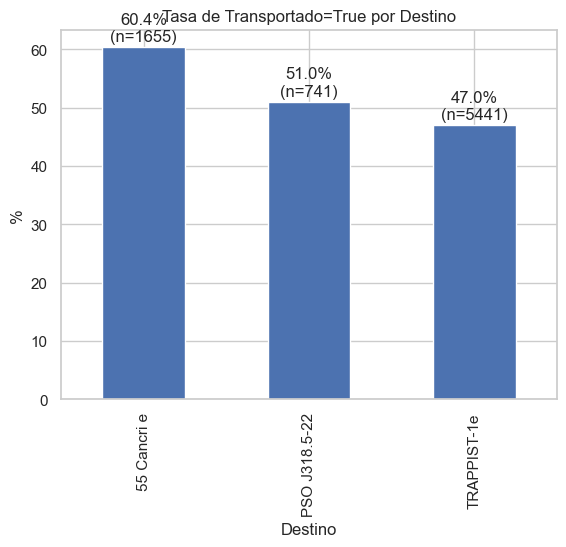

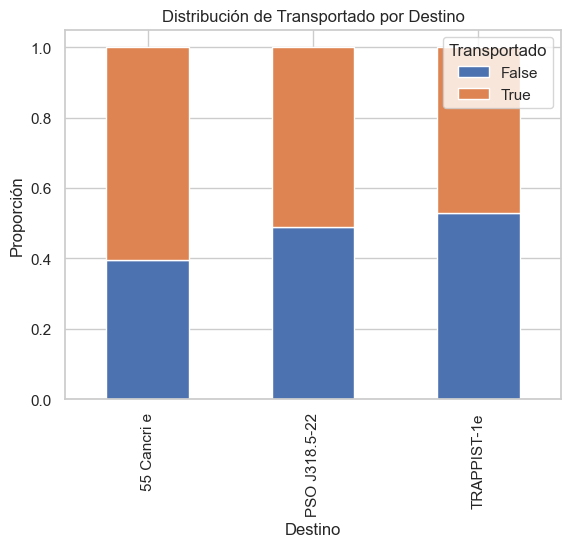

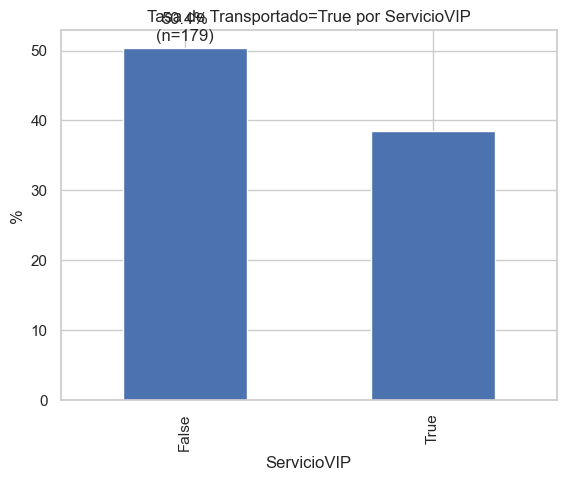

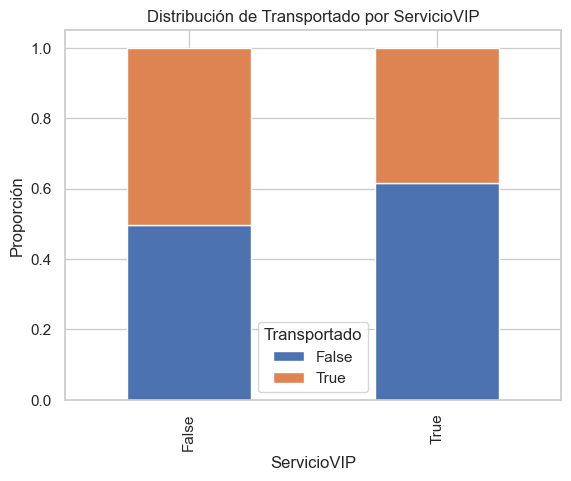

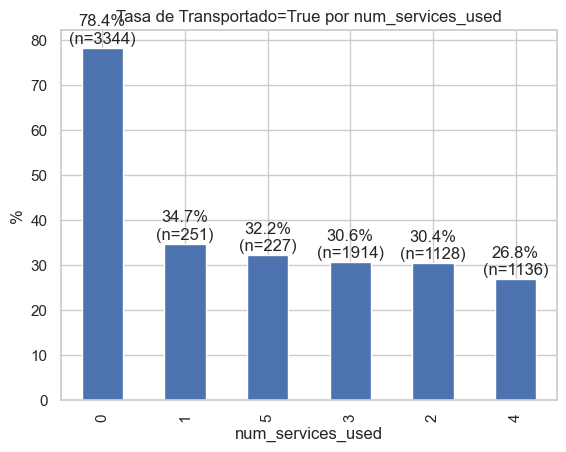

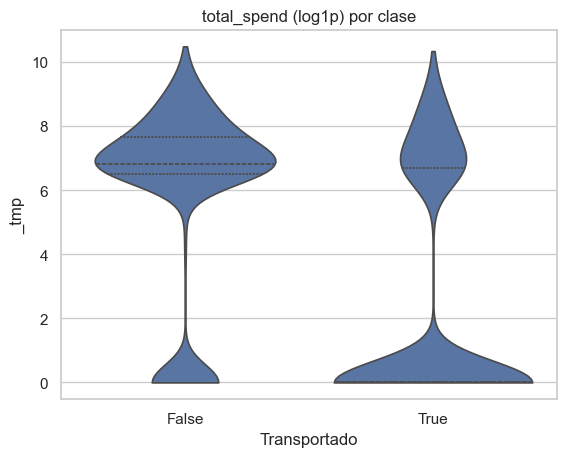

In [296]:
sns.set(style="whitegrid")

# ========= Helpers =========
def plot_label_balance(df, y="Transportado"):
    rates = df[y].value_counts(normalize=True).sort_index()
    ax = rates.mul(100).plot(kind="bar")
    ax.set_title("Balance de la etiqueta")
    ax.set_ylabel("%")
    for i,v in enumerate(rates.mul(100)):
        ax.text(i, v+1, f"{v:.1f}%", ha="center")
    plt.show()

def plot_rate_by_category(df, col, y="Transportado"):
    """Bar plot de la tasa P(y=True | col) con conteos sobre las barras."""
    rates = pd.crosstab(df[col], df[y], normalize="index")[True].sort_values(ascending=False)
    counts = df[col].value_counts().loc[rates.index]
    ax = rates.mul(100).plot(kind="bar")
    ax.set_title(f"Tasa de {y}=True por {col}")
    ax.set_ylabel("%")
    for i,(p,c) in enumerate(zip(rates.mul(100), counts)):
        ax.text(i, p+1, f"{p:.1f}%\n(n={c})", ha="center")
    plt.show()

def plot_stacked_prop(df, col, y="Transportado"):
    """Barras apiladas normalizadas (proporción por categoría)."""
    tab = pd.crosstab(df[col], df[y], normalize="index")
    ax = tab.plot(kind="bar", stacked=True)
    ax.set_title(f"Distribución de {y} por {col}")
    ax.set_ylabel("Proporción")
    plt.legend(title=y, loc="best")
    plt.show()

def box_violin_numeric(df, col, y="Transportado", log=False):
    tmp = df[[col, y]].copy()
    shown_col = col
    if log:
        tmp["_tmp"] = np.log1p(tmp[col])
        shown_col = "_tmp"
        title_col = f"{col} (log1p)"
    else:
        title_col = col

    sns.violinplot(data=tmp, x=y, y=shown_col, cut=0, inner="quartile")
    plt.title(f"{title_col} por clase")
    plt.show()

# ========= Visualizaciones rápidas =========

# 1) Balance de etiqueta
plot_label_balance(train_df, "Transportado")

# 2) Tasas por categoría (elige las que te interesen)
for c in ["SuenoCriogenico","PlanetaOrigen","Destino","ServicioVIP"]:
    plot_rate_by_category(train_df, c, "Transportado")
    plot_stacked_prop(train_df, c, "Transportado")

# 3) Crear y visualizar features derivados de gasto
gastos_df = train_df.copy()
gastos = ["ServicioHabitacion","Cafeteria","CentroComercial","Spa","CubiertaVR"]
for g in gastos:
    gastos_df[f"{g}_gt0"] = (gastos_df[g] > 0).astype(int)
gastos_df["total_spend"] = gastos_df[gastos].sum(axis=1)
gastos_df["num_services_used"] = gastos_df[[f"{g}_gt0" for g in gastos]].sum(axis=1)

plot_rate_by_category(gastos_df, "num_services_used", "Transportado")
box_violin_numeric(gastos_df, "total_spend", "Transportado", log=True)


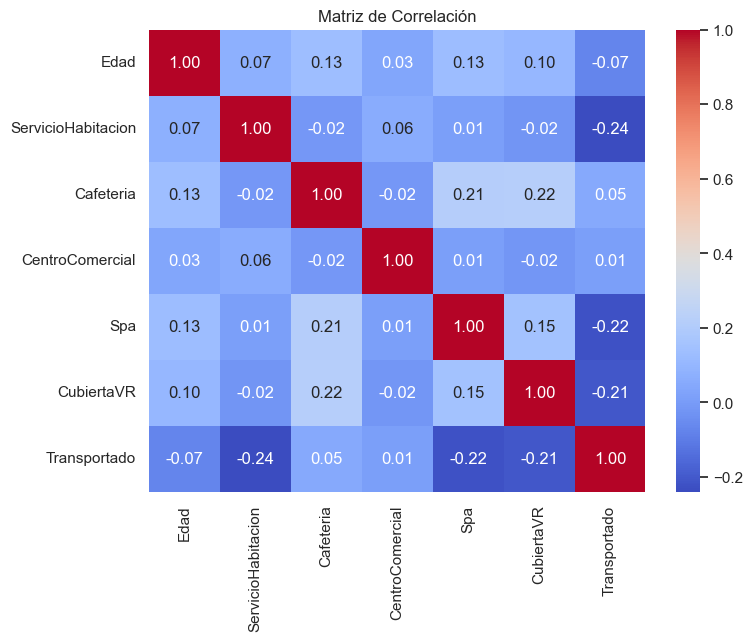

Transportado          1.000000
Cafeteria             0.051358
CentroComercial       0.010145
Edad                 -0.073805
CubiertaVR           -0.205830
Spa                  -0.222618
ServicioHabitacion   -0.238996
Name: Transportado, dtype: float64

In [297]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

corr['Transportado'].sort_values(ascending=False)

En la matriz de relación ningun parametro parecia realmente fuerte, entre los de mayor influencia negativa eran:
- ServicioHabitación (-0.24)
- Spa (-0.22)
- CubiertaVR (-0.20)

Esto formo una supuesta hipotesis de a menor gasto menor la probabilidad de ser transportados, ante eso se penso en el resto de los parametros categoricos y en el siguiente escenario
Si la persona se encuentra en Sueño Criogenico, no usará los servicios por lo que tendra un menor gasto o igual a 0


En la gráfica 'Distribución de Transportado por SuenoCriogenico' se puede observar una correlación interesante entre SuenoCruogenico y Transportado donde:
- SuenoCruogenico == True
- Transportado == True

Donde se observa que el 81.2% de las personas que se encontraban e SuenoCruogenico fueron trasnportadas


**Paso 2: Limpieza de Datos e Ingeniería de Características**

Para los valores nulos en caso de que el valor sea numerico usé la mediana de los datos para sustituirlo, en caso de que fuera categorico elimine por completo la fila.

In [7]:
faltantes = train_df.isnull().sum().sort_values(ascending=False)
porcentaje = (train_df.isnull().mean()*100).sort_values(ascending=False) # Computes the mean of each column, treating True as 1 and False as 0,
missing_df = pd.DataFrame({'Valores Faltantes': faltantes, '% Faltante': porcentaje.round(2)})
missing_df

,Valores Faltantes,% Faltante
SuenoCriogenico,197,2.46
CentroComercial,191,2.39
ServicioVIP,188,2.35
Cabina,179,2.24
PlanetaOrigen,177,2.21
CubiertaVR,174,2.17
Spa,173,2.16
Edad,165,2.06
Destino,163,2.04
ServicioHabitacion,161,2.01


In [8]:
# Seleccionar columnas numéricas
num_col = train_df.select_dtypes(include=['number']).columns

# Imputación de valores faltantes con la mediana para cada columna numérica
for col in num_col:
    if train_df[col].isnull().any():
        mediana = train_df[col].median()
        train_df[col] = train_df[col].fillna(mediana)
        print(f"Imputados valores faltantes en '{col}' con la mediana = {mediana}")
    else:
        print(f"No se encontraron valores faltantes en '{col}'.")

# Verificación rápida
print("\nValores faltantes restantes en todo el DataFrame:", train_df.isnull().sum().sum())

Imputados valores faltantes en 'Edad' con la mediana = 27.0
Imputados valores faltantes en 'ServicioHabitacion' con la mediana = 0.0
Imputados valores faltantes en 'Cafeteria' con la mediana = 0.0
Imputados valores faltantes en 'CentroComercial' con la mediana = 0.0
Imputados valores faltantes en 'Spa' con la mediana = 0.0
Imputados valores faltantes en 'CubiertaVR' con la mediana = 0.0

Valores faltantes restantes en todo el DataFrame: 904


**Mediana en numericas:** Las distribuciones de gasto son cero-infladas y muy sesgadas, con outliers grandes (se vio en describe() y boxplots), esto provoca que la media se desplace a diferencia de la mediana la cual es robusta y mantiene el centro real de la masa de datos.
Otro punto a considerar es que el % de nulos es bajo (~2%) por columna, así que la mediana introduce poco ruido y es estable.


In [9]:
# Identificar columnas categóricas
cat_col = train_df.select_dtypes(include=['object', 'category']).columns.union(['Transportado'])

# Eliminar filas con valores faltantes en cualquier columna categórica
before = len(train_df)
train_df = train_df.dropna(subset=cat_col)
after = len(train_df)

print(f"Filas eliminadas por valores faltantes en columnas categóricas: {before - after}")
# Verificación rápida
print("\nValores faltantes restantes en todo el DataFrame:", train_df.isnull().sum().sum())

Filas eliminadas por valores faltantes en columnas categóricas: 864

Valores faltantes restantes en todo el DataFrame: 0


**Eliminar fila categórica:**
- Evito categorias “artificiales”, si agregara una categoria de “Desconocida” o algo parecido haría que los modelos aprendar a identificarla en lugar del patron real
- En caso de booleanos imputar con la moda cambia la base (si VIP=True ya es poco frecuente, imputar False por defecto sesga más).
- Además aún eliminando 10.8% queda un amplio numero de datos (7k+) por lo que la reducción de varianza por datos “limpios” compensa el ligero aumento de varianza por menor tamaño.


In [10]:
train_df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = train_df['Cabina'].str.split('/', expand=True)
train_df = train_df.drop(columns=['IdPasajero', 'Iniciales', 'Cabina'])
train_df.NumCabina = train_df.NumCabina.astype(int)

Para poder utilizar la columna de cabina sin generar miles de columnas al aplicar one hot encoding lo dividimos en 3 columnas:

- CubiertaCabina
- NumCabina
- LadoCabina

Debido a que podría llegar a tener importancia de coorelacion la ubicación de esta misma con su estado de Transportado

In [11]:
cat_col = train_df.select_dtypes(include=['object', 'category']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
encoded = encoder.fit_transform(train_df[cat_col])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(train_df[cat_col].columns),
    index=train_df.index
)

encoded_df.head()

,PlanetaOrigen_Earth,PlanetaOrigen_Europa,PlanetaOrigen_Mars,SuenoCriogenico_True,Destino_55 Cancri e,Destino_PSO J318.5-22,Destino_TRAPPIST-1e,ServicioVIP_True,CubiertaCabina_A,CubiertaCabina_B,CubiertaCabina_C,CubiertaCabina_D,CubiertaCabina_E,CubiertaCabina_F,CubiertaCabina_G,CubiertaCabina_T,LadoCabina_S
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
num_col = train_df.select_dtypes(include=['number']).columns.union(["NumCabina"])
scaler = StandardScaler()
scaled = scaler.fit_transform(train_df[num_col])

scaled_df = pd.DataFrame(scaled, columns=num_col, index=train_df.index)
scaled_df.head()

,Cafeteria,CentroComercial,CubiertaVR,Edad,NumCabina,ServicioHabitacion,Spa
1,1.855688,-0.283175,-0.256958,-0.753424,-0.665209,-0.343660,0.170020
2,0.275622,-0.255236,3.019962,1.051191,-1.109802,1.904125,1.000341
3,-0.213329,-0.283175,-0.263904,1.328824,-1.121502,-0.343660,1.049493
4,-0.281256,1.128554,0.415097,2.716988,1.854154,0.490685,-0.097684
5,-0.278808,-0.131977,-0.263904,1.537048,-0.825107,0.962895,-0.240752


In [13]:
final_train_df = pd.concat([scaled_df, encoded_df], axis=1)
final_train_df.head()

,Cafeteria,CentroComercial,CubiertaVR,Edad,NumCabina,ServicioHabitacion,Spa,PlanetaOrigen_Earth,PlanetaOrigen_Europa,PlanetaOrigen_Mars,...,ServicioVIP_True,CubiertaCabina_A,CubiertaCabina_B,CubiertaCabina_C,CubiertaCabina_D,CubiertaCabina_E,CubiertaCabina_F,CubiertaCabina_G,CubiertaCabina_T,LadoCabina_S
1,1.855688,-0.283175,-0.256958,-0.753424,-0.665209,-0.343660,0.170020,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.275622,-0.255236,3.019962,1.051191,-1.109802,1.904125,1.000341,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.213329,-0.283175,-0.263904,1.328824,-1.121502,-0.343660,1.049493,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.281256,1.128554,0.415097,2.716988,1.854154,0.490685,-0.097684,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,-0.278808,-0.131977,-0.263904,1.537048,-0.825107,0.962895,-0.240752,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Paso 4: Entrenamiento y Evaluación del Modelo**

Se hicieron pruebas con los modelos XGBoost, Random Forest y Logistic Regression. XGBoost tuvo un mejor desempeño porque puede capturar relaciones no lineales y complejas entre las variables. A diferencia de la regresión logística, no asume linealidad, y frente a Random Forest, su enfoque de *boosting* ajusta los errores de forma secuencial, usando regularización y optimización más eficiente. Esto le permite lograr un mejor equilibrio entre sesgo y varianza.


In [14]:
x = final_train_df
y = train_df["Transportado"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Accuracy: 0.8123249299719888


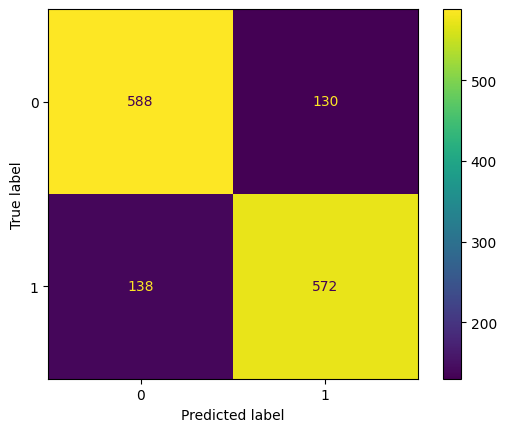

In [15]:
xgboost_ = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'  # avoids warning
)

xgboost_.fit(x_train, y_train)
y_pred = xgboost_.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


El modelo tiene un desempeño bueno, con una precisión general del 81%. Esto indica que logra predecir correctamente la mayoría de los casos de pasajeros transportados y no transportados.

Se equivoca ligeramente más en el segmento de falsos negativos ya que tiene 138 frente a 130 falsos positivos.
Esto significa que, con más frecuencia, predice que un pasajero no fue transportado cuando en realidad sí lo fue.

**Paso 5: Generación del Archivo de Entrega**

In [19]:
def full_preprocess(df, ids):
    # # imputar valores numéricos faltantes
    # num_col = df.select_dtypes(include=['number']).columns

    # for col in num_col:
    #     if df[col].isnull().any():
    #         mediana = df[col].median()
    #         df[col] = df[col].fillna(mediana)
    #         print(f"Imputados valores faltantes en '{col}' con la mediana = {mediana}")
    #     else:
    #         print(f"No se encontraron valores faltantes en '{col}'.")
            
    # print("\nValores faltantes restantes en todo el DataFrame:", df.isnull().sum().sum())

    # # eliminar valores categóricos faltantes
    # cat_col = df.select_dtypes(include=['object', 'category']).columns

    # before = len(df)
    # df = df.dropna(subset=cat_col)
    # after = len(df)

    # print(f"Filas eliminadas por valores faltantes en columnas categóricas: {before - after}")
    # print("\nValores faltantes restantes en todo el DataFrame:", df.isnull().sum().sum())

    # separar la cabina en 3 partes
    df[['CubiertaCabina', 'NumCabina', 'LadoCabina']] = df['Cabina'].str.split('/', expand=True)
    df.NumCabina = train_df.NumCabina.astype(int)

    ids.append(df.IdPasajero)

    # eliminar columnas irrelevantes
    df = df.drop(columns=['IdPasajero', 'Iniciales', 'Cabina'])

    # aplicar one hot encoding
    cat_col = df.select_dtypes(include=['object', 'category']).columns
    encoded = encoder.transform(df[cat_col])

    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(df[cat_col].columns),
        index=df.index
    )

    # escalar datos numéricos 
    num_col = df.select_dtypes(include=['number']).columns.union(['NumCabina'])
    scaled = scaler.transform(df[num_col])

    scaled_df = pd.DataFrame(scaled, columns=num_col, index=df.index)

    # concatenar datos numéricos y categóricos
    return pd.concat([scaled_df, encoded_df], axis=1)

In [20]:
eval_df = pd.read_csv(eval_data_path)

ids = []
final_eval_df = full_preprocess(eval_df, ids)
y_pred = xgboost_.predict(final_eval_df)

c:\Users\mauro\OneDrive\Documents\Tareas\9no_Semestre\Aplicaciones_Avanzadas\Inteligencia artificial\Odisea Cósmica\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
out = pd.DataFrame(ids[0], columns=["IdPasajero"])
out['Transportado'] = [str(y == 1).upper() for y in y_pred]

out.to_csv("out.csv", index=False)